### Gather required libraries

In [ ]:
# Initialize the normalized data list for the substrate
substrate_data_norm = []

# Initialize a dictionary to store normalized data for products
product_data_norm = {}

# Extract column names for products dynamically (excluding the 'Substrate' column)
product_columns = [col for col in data.columns if col.startswith("Product_")]

# Initialize lists in the dictionary for each product column
for product in product_columns:
    product_data_norm[product] = []

for i in range(len(data)):  # Dynamically get the number of rows from the data
    # Take column of the data frame
    d1 = data["Substrate"]
    
    # Sum the total amount in each row for products
    d_total = d1[i] + sum(data[product][i] for product in product_columns)
    
    # Normalize the substrate
    sub_norm = d1[i] / d_total
    sub_norm = round(sub_norm, 3)
    substrate_data_norm.append(sub_norm)
    
    # Normalize each product dynamically
    for product in product_columns:
        prod_norm = data[product][i] / d_total
        prod_norm = round(prod_norm, 3)
        product_data_norm[product].append(prod_norm)

# Assign normalized data back to the dataframe
data["Substrate_norm"] = substrate_data_norm
for product in product_columns:
    data[f"{product}_norm"] = product_data_norm[product]

data


In [1]:
import scipy
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
import pandas as pd

### Import test data

In [8]:
# this will be included in the previous notebook - data preparation from the gel

data = pd.read_csv("test_data.csv", comment='#',sep=',') #T19T + U19G CY5
data

,Time_Points,Substrate,Product_1,Product_2,Product_3
0,0,1.000,0.000,0.000,0.000
1,10,0.632,0.034,0.078,0.256
2,30,0.288,0.132,0.224,0.356
3,60,0.211,0.135,0.259,0.394
4,180,0.133,0.147,0.287,0.434
5,360,0.096,0.143,0.303,0.458
6,1800,0.065,0.251,0.187,0.496
7,6000,0.000,0.193,0.279,0.528


In [14]:
# Initial data (time and substrate concentration)
time_data = np.array(data["Time_Points"])  # Time points
substrate_data = np.array(data["Substrate"])  # Substrate concentration over time
product_data = (np.array(data["Product_1"]), # Product 1
                np.array(data["Product_2"]),  # Product 2 
                np.array(data["Product_3"]) # Product 3
               )  

# Filter out products with all zero values
filtered_product_data = [pd for pd in product_data if not all(v == 0 for v in pd)] #if the array is all 0's, it is omitted

# Decide from the input array how many products there are
n_products = len(filtered_product_data)

### Define functions

In [17]:
# ODE system 
def ode_system(t, y, params, n_products):
    S = y[0]
    dSdt = 0
    dPdt = [0] * n_products

    # Split params into formation and trimming rates
    k_formation = params[:n_products]
    k_trimming = params[n_products:]

    # Substrate depletion
    dSdt = -np.sum([k_formation[i] * S for i in range(n_products)])

    # Product formation directly from substrate
    for i in range(n_products):
        dPdt[i] += k_formation[i] * S

    # Product trimming between products
    k_trimming_index = 0
    for i in range(n_products):
        
        for j in range(i + 1, n_products):
            trimming_rate = k_trimming[k_trimming_index-1]
            dPdt[j] += trimming_rate * y[i]  # Trimming from Product i to Product j
            dPdt[i] -= trimming_rate * y[i]  # Reduction in Product i due to trimming
            k_trimming_index += 1

    return [dSdt] + dPdt

# Fitting function
def fitting_function(params, n_products, substrate_data, product_data):
    y0 = [substrate_data[0]] + [pd[0] for pd in product_data]
    sol = solve_ivp(
        lambda t, y: ode_system(t, y, params, n_products),
        [time_data[0], time_data[-1]],
        y0,
        t_eval=time_data,
        method='LSODA'
    )
    y_predicted = sol.y
    residuals = [y_predicted[0] - substrate_data]
    for i in range(n_products):
        residuals.append(y_predicted[i + 1] - product_data[i])
    return np.concatenate(residuals)

# Function to calculate R-squared
def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

# Function to calculate Sum of Squared Residuals (SSR)
def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

### Perform fitting

In [20]:
# Initial guess for parameters
n_trimming_params = (n_products * (n_products - 1)) // 2
initial_guess = [0.1] * n_products + [0.1] * n_trimming_params  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
bounds = (0, np.inf)  # Bounds to ensure non-negative parameters
result = least_squares(
    fitting_function, 
    initial_guess, 
    bounds=bounds, 
    args=(n_products, substrate_data, filtered_product_data)
)

# Extract the optimal parameters
optimal_params = result.x
k_formation_opt = optimal_params[:n_products]
k_trimming_opt = optimal_params[n_products:]

### Plot the fitting

Optimal formation rates by product:
Product 1: k_formation = 0.030076
Product 2: k_formation = 0.002977
Product 3: k_formation = 0.005530

Optimal trimming rates:
Product 1 to Product 2: k_trimming = 0.013516
Product 1 to Product 3: k_trimming = 0.000036
Product 2 to Product 3: k_trimming = 0.008838


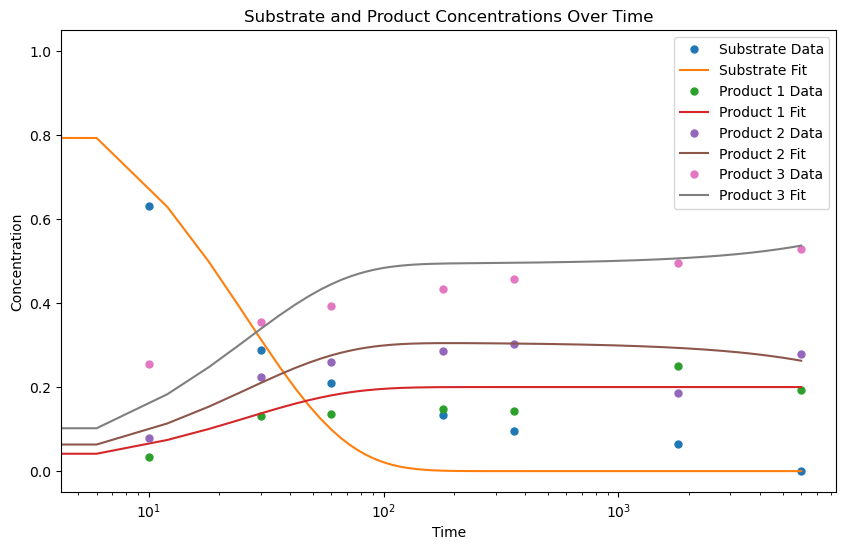

In [23]:
# Print the optimal parameters by product
print("Optimal formation rates by product:")
for i in range(n_products):
    print(f"Product {i + 1}: k_formation = {k_formation_opt[i]:.6f}")

print("\nOptimal trimming rates:")
k_trimming_index = 0
for i in range(n_products):
    for j in range(i + 1, n_products):
        print(f"Product {i + 1} to Product {j + 1}: k_trimming = {k_trimming_opt[k_trimming_index]:.6f}")
        k_trimming_index += 1

# Evaluate the fit quality
y0 = [substrate_data[0]] + [pd[0] for pd in filtered_product_data]
sol = solve_ivp(
    lambda t, y: ode_system(t, y, optimal_params, n_products),
    [time_data[0], time_data[-1]],
    y0,
    t_eval=time_data,
    method='LSODA'
)
y_predicted = sol.y

# Time values for plotting
x_values = np.linspace(0, 6000, 1000)
sol_plot = solve_ivp(
    lambda t, y: ode_system(t, y, optimal_params, n_products),
    [x_values[0], x_values[-1]],
    y0,
    t_eval=x_values,
    method='LSODA')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_data, substrate_data, 'o', label='Substrate Data', markersize=5)
plt.plot(x_values, sol_plot.y[0], '-', label='Substrate Fit')

for i in range(n_products):
    plt.plot(time_data, filtered_product_data[i], 'o', label=f'Product {i + 1} Data', markersize=5)
    plt.plot(x_values, sol_plot.y[i + 1], '-', label=f'Product {i + 1} Fit')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Substrate and Product Concentrations Over Time')
plt.xscale('log')
plt.legend()
plt.show()

### Evaluate the fitting

In [26]:
print("\nR-squared values by product:")
r2_substrate = r_squared(substrate_data, y_predicted[0])
print(f"Substrate: R-squared = {r2_substrate:.6f}")
for i in range(n_products):
    r2_product = r_squared(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: R-squared = {r2_product:.6f}")

print("\nSum of Squared Residuals (SSR) by product:")
ssr_substrate = sum_squared_residuals(substrate_data, y_predicted[0])
print(f"Substrate: SSR = {ssr_substrate:.6f}")
for i in range(n_products):
    ssr_product = sum_squared_residuals(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: SSR = {ssr_product:.6f}")


R-squared values by product:
Substrate: R-squared = 0.943547
Product 1: R-squared = 0.741167
Product 2: R-squared = 0.847138
Product 3: R-squared = 0.912433

Sum of Squared Residuals (SSR) by product:
Substrate: SSR = 0.046457
Product 1: SSR = 0.011702
Product 2: SSR = 0.012763
Product 3: SSR = 0.017791


### Good example

Optimal formation rates by product:
Product 1: k_formation = 0.004593
Product 2: k_formation = 0.007125
Product 3: k_formation = 0.011782

Optimal trimming rates by product:
Product 1 to Product 2: k_trimming = 0.000000
Product 1 to Product 3: k_trimming = 0.000000
Product 2 to Product 3: k_trimming = 0.000022
Product 2 to Product 4: k_trimming = 0.000022

R-squared values by product:
Substrate: R-squared = 0.758764
Product 1: R-squared = 0.741167
Product 2: R-squared = 0.847138
Product 3: R-squared = 0.912433

Sum of Squared Residuals (SSR) by product:
Substrate: SSR = 0.211484
Product 1: SSR = 0.011702
Product 2: SSR = 0.012763
Product 3: SSR = 0.017791


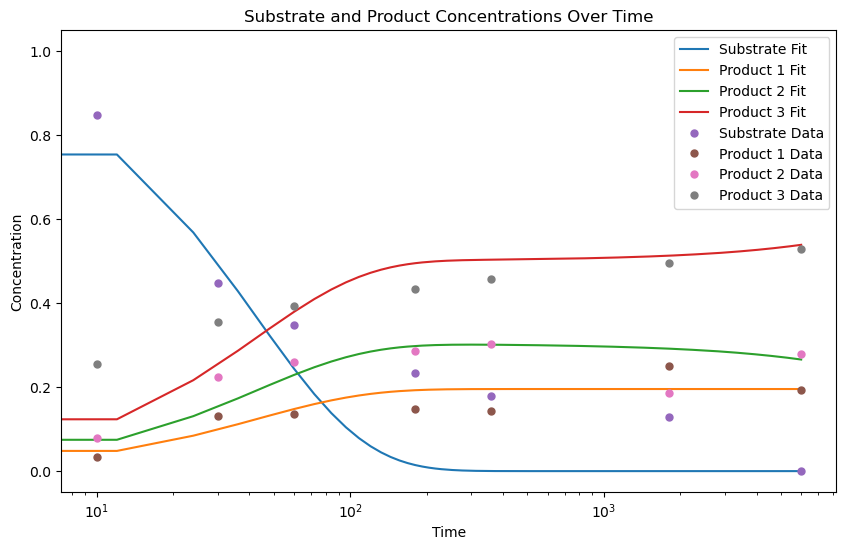

In [29]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Example data (you can change this to any number of products)
time_data = [0, 10, 30, 60, 180, 360, 1800, 6000]  # Time points
substrate_data = [1, 0.849, 0.447, 0.349, 0.234, 0.178, 0.129, 0]  # Substrate concentration over time
product_data = ([0, 0.034, 0.132, 0.135, 0.147, 0.143, 0.251, 0.193], # Product 1
                [0, 0.078, 0.224, 0.259, 0.287, 0.303, 0.187, 0.279], # Product 2
                [0, 0.256, 0.356, 0.394, 0.434, 0.458, 0.496, 0.528] # Product 3
               )

# Filter out products with all zero values
filtered_product_data = [pd for pd in product_data if not all(v == 0 for v in pd)]
n_products = len(filtered_product_data)

# ODE system definition
def ode_system(t, y, params, n_products):
    S = y[0]
    dSdt = 0
    dPdt = [0] * n_products

    # Split params into formation and trimming rates
    k_formation = params[:n_products]
    k_trimming = params[n_products:]

    # Substrate depletion
    dSdt = -np.sum([k_formation[i] * S for i in range(n_products)])

    # Product formation and trimming
    dPdt[0] = k_formation[0] * S
    for i in range(1, n_products):
        dPdt[i] += k_formation[i] * S  # Formation directly from substrate
        dPdt[i] += k_trimming[i - 1] * y[i]  # Trimming from the previous product 
        dPdt[i - 1] -= k_trimming[i - 1] * y[i]  # Reduction in the previous product due to trimming

    return [dSdt] + dPdt

# Fitting function
def fitting_function(params, n_products, substrate_data, product_data):
    y0 = [substrate_data[0]] + [pd[0] for pd in product_data]
    sol = solve_ivp(
        lambda t, y: ode_system(t, y, params, n_products),
        [time_data[0], time_data[-1]],
        y0,
        t_eval=time_data,
        method='LSODA'
    )
    y_predicted = sol.y
    residuals = [y_predicted[0] - substrate_data]
    for i in range(n_products):
        residuals.append(y_predicted[i + 1] - product_data[i])
    return np.concatenate(residuals)

# Function to calculate R-squared
def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

# Function to calculate Sum of Squared Residuals (SSR)
def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Initial guess for parameters
initial_guess = [0.1] * (n_products * 2 - 1)  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
bounds = (0, np.inf)  # Bounds to ensure non-negative parameters
result = least_squares(
    fitting_function, 
    initial_guess, 
    bounds=bounds, 
    args=(n_products, substrate_data, filtered_product_data)
)

# Extract the optimal parameters
optimal_params = result.x
k_formation_opt = optimal_params[:n_products]
k_trimming_opt = optimal_params[n_products:]

# Print the optimal parameters by product
print("Optimal formation rates by product:")
for i in range(n_products):
    print(f"Product {i + 1}: k_formation = {k_formation_opt[i]:.6f}")

print("\nOptimal trimming rates by product:")
for i in range(n_products - 1):
    print(f"Product {i + 1} to Product {i + 2}: k_trimming = {k_trimming_opt[i]:.6f}")
    print(f"Product {i + 1} to Product {i + 3}: k_trimming = {k_trimming_opt[i]:.6f}")
    
print("\nR-squared values by product:")
r2_substrate = r_squared(substrate_data, y_predicted[0])
print(f"Substrate: R-squared = {r2_substrate:.6f}")
for i in range(n_products):
    r2_product = r_squared(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: R-squared = {r2_product:.6f}")

print("\nSum of Squared Residuals (SSR) by product:")
ssr_substrate = sum_squared_residuals(substrate_data, y_predicted[0])
print(f"Substrate: SSR = {ssr_substrate:.6f}")
for i in range(n_products):
    ssr_product = sum_squared_residuals(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: SSR = {ssr_product:.6f}")


# Generate smooth time points
smooth_time_data = np.linspace(time_data[0], time_data[-1], 500)

# Solve the ODE system with optimal parameters at smooth time points
smooth_y0 = [substrate_data[0]] + [pd[0] for pd in filtered_product_data]
smooth_sol = solve_ivp(
    lambda t, y: ode_system(t, y, optimal_params, n_products),
    [time_data[0], time_data[-1]],
    smooth_y0,
    t_eval=smooth_time_data,
    method='LSODA'
)
smooth_y_predicted = smooth_sol.y

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot smooth lines for substrate
plt.plot(smooth_time_data, smooth_y_predicted[0], '-', label='Substrate Fit')

# Plot smooth lines for products
for i in range(n_products):
    plt.plot(smooth_time_data, smooth_y_predicted[i + 1], '-', label=f'Product {i + 1} Fit')

# Plot data points
plt.plot(time_data, substrate_data, 'o', label='Substrate Data', markersize=5)
for i in range(n_products):
    plt.plot(time_data, filtered_product_data[i], 'o', label=f'Product {i + 1} Data', markersize=5)

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Substrate and Product Concentrations Over Time')
plt.legend()
plt.xscale('log')
plt.show()
